In [1]:
import numpy as np

class GridWorld:
    def __init__(self):
        # Grid dimensions
        self.rows = 5
        self.cols = 5
        self.states = [(r, c) for r in range(self.rows) for c in range(self.cols)]
        # Define states
        self.obstacles = [(2, 2), (3, 2)]  # Obstacle states
        self.water = (4, 2)                # Water state
        self.goal = (4, 4)                 # Goal state
        
        # Define actions
        self.actions = ['AU', 'AD', 'AL', 'AR']  # Up, Down, Left, Right
        
        # Action probabilities
        self.p_intended = 0.8    # Probability of moving in intended direction
        self.p_side = 0.05      # Probability of veering left/right
        self.p_stay = 0.10      # Probability of staying in place
        
        # Current state
        self.current_state = (0, 0)  # Start at State 1
        
    def is_valid_state(self, state):
        """Check if state is valid (within bounds and not obstacle)"""
        r, c = state
        return (0 <= r < self.rows and 
                0 <= c < self.cols and 
                state not in self.obstacles)
    
    def get_next_state(self, state, action):
        """Get next state based on current state and action"""
        r, c = state
        
        # Define movement directions (up, down, left, right)
        movements = {
            'AU': (-1, 0),
            'AD': (1, 0),
            'AL': (0, -1),
            'AR': (0, 1)
        }
        
        # Get intended movement
        dr, dc = movements[action]
        new_r, new_c = r + dr, c + dc
        
        # Check if move is valid
        if self.is_valid_state((new_r, new_c)):
            return (new_r, new_c)
        return state  # Stay in current state if invalid move
    
    def step(self, action):
        """Take a step in the environment"""
        if action not in self.actions:
            raise ValueError("Invalid action")
            
        # Determine actual movement based on probabilities
        p = np.random.random()
        
        if p < self.p_stay:  # 10% chance to stay
            actual_action = None
        elif p < self.p_stay + self.p_intended:  # 80% chance for intended action
            actual_action = action
        else:  # 5% chance each for left/right deviation
            if action in ['AU', 'AD']:
                actual_action = 'AL' if p < 0.95 else 'AR'
            else:  # AL, AR
                actual_action = 'AU' if p < 0.95 else 'AD'
        
        # Update state
        if actual_action:
            self.current_state = self.get_next_state(self.current_state, actual_action)
        
        # Calculate reward
        reward = 10.0 if self.current_state == self.goal else -10.0 if self.current_state == self.water else 0.0
        
        # Check if episode is done
        done = self.current_state == self.goal
        
        return self.current_state, reward, done
    
    def reset(self):
        """Reset environment to initial state"""
        self.current_state = (0, 0)
        return self.current_state



In [19]:
import copy
import time
class Node:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        self.children = []
        self._number_of_visits = 0
        self._total_reward = 0
        self._untried_actions = None  # Will be initialized when needed
        self.is_terminal = False

    @property
    def q_value(self):
        """Average reward for this node"""
        return self._total_reward / (self._number_of_visits + 1e-10)

    @property
    def untried_actions(self):
        """Lazy initialization of untried actions"""
        return self._untried_actions

    @untried_actions.setter
    def untried_actions(self, actions):
        self._untried_actions = actions

class MonteCarloSearchTree:
    def __init__(self, env, gamma=0.95):
        self.gamma = gamma
        self.env = env
        self.root = Node((0,0))
        # Initialize untried actions for root
        self.root.untried_actions = env.actions.copy()

    def _select(self, node):
        """Select a node to expand using UCT."""
        current = node
        while current.children:  # While node has children
            if current.untried_actions:  # If there are untried actions
                return current
            
            # UCT formula adapted for continuous rewards
            c = 10  # Exploration parameter
            children_weights = [
                (child, 
                 child.q_value + 
                 c * np.sqrt(np.log(current._number_of_visits) / (child._number_of_visits + 1e-10)))
                for child in current.children
            ]
            current = max(children_weights, key=lambda x: x[1])[0]
        return current

    def _expand(self, node):
        """Expand node by trying an untried action."""
        action = node.untried_actions.pop()
        # Create temporary environment for simulation
        temp_env = copy.deepcopy(self.env)
        temp_env.current_state = node.state
        next_state, reward, done = temp_env.step(action)
        
        child = Node(next_state, parent=node)
        child.is_terminal = done
        if not done:
            child.untried_actions = self.env.actions.copy()
        node.children.append(child)
        return child

    def _rollout(self, node):
        """Perform random rollout from node."""
        temp_env = copy.deepcopy(self.env)
        temp_env.current_state = node.state
        cumulative_reward = 0
        depth = 0
        max_depth = 100  # Prevent infinite rollouts
        
        while not temp_env.current_state == temp_env.goal and depth < max_depth:
            action = np.random.choice(temp_env.actions)
            _, reward, done = temp_env.step(action)
            cumulative_reward += (self.gamma ** depth) * reward
            depth += 1
            if done:
                break
                
        return cumulative_reward

    def _backpropagate(self, node, reward):
        """Backpropagate the reward through the tree."""
        current = node
        while current is not None:
            current._number_of_visits += 1
            current._total_reward += reward
            current = current.parent
            reward *= self.gamma

    def get_best_action(self, time_limit=1.0):
        """Return best action based on search results."""
        start_time = time.time()
        plottingmaterials = []
        while time.time() - start_time < time_limit:
            node = self._select(self.root)
            if not node.is_terminal and node.untried_actions:
                node = self._expand(node)
                reward = self._rollout(node)
                self._backpropagate(node, reward)
            # print(f'root reward: {self.root.q_value}')
            avg_reward,min_reward,max_reward = self.find_stats_reward(self.root)
            time_taken = time.time() - start_time
            plottingmaterials.append((time_taken, avg_reward,min_reward,max_reward))
        
        # Choose action that leads to child with highest Q-value
        best_child = max(self.root.children, 
                        key=lambda child: child.q_value)
        return self._get_action(self.root, best_child),plottingmaterials
    def find_stats_reward(self,node):
        return node.q_value,min(node.children,key=lambda x:x.q_value).q_value,max(node.children,key=lambda x:x.q_value).q_value
    def _get_action(self, parent, child):
        """Determine action that leads from parent to child."""
        for action in self.env.actions:
            temp_env = copy.deepcopy(self.env)
            temp_env.current_state = parent.state
            next_state, _, _ = temp_env.step(action)
            if next_state == child.state:
                return action
        return None

In [20]:
env = GridWorld()
mcts = MonteCarloSearchTree(env)

best_action,plottingmaterials = mcts.get_best_action(30)
#plot the time vs reward
#plot in log scale iteration


In [26]:
# Get optimal policy by finding action that leads to child with highest Q-value for each state
optimal_policy = {}
optimal_values = {}
for state in env.states:
    if state == env.goal or state in env.obstacles:
        continue
    # Find child nodes corresponding to this state
    children = [c for c in mcts.root.children if c.state == state]
    if children:
        best_child = max(children, key=lambda c: c.q_value)
        optimal_policy[state] = mcts._get_action(mcts.root, best_child)
        optimal_values[state] = best_child.q_value

# print policy in table with arrows
def print_policy(policy):
    for i in range(5):
        for j in range(5):
            state = (i, j)
            if state is env.goal:
                print("G", end=" ")
                continue
            elif state in env.obstacles:
                print("O", end=" ")
                continue
            action = policy.get(state)
            if action == 'AU':
                print("↑", end=" ")
            elif action == 'AD':
                print("↓", end=" ")
            elif action == 'AL':
                print("←", end=" ")
            elif action == 'AR':
                print("→", end=" ")
            else:
                print(" ", end=" ")
        print()

def print_values(values):
    for i in range(5):
        for j in range(5):
            state = (i, j)
            if state is env.goal:
                print("0.00", end=" ")
                continue
            elif state in env.obstacles:
                print("0.00", end=" ")
                continue
            value = values.get(state, 0.0)
            print(f"{value:.2f}", end=" ")
        print()

print_policy(optimal_policy)
print_values(optimal_values)
mcts.print_tree(mcts.root)

↑ →       
↓         
    O     
    O     
          
-1.72 -0.80 0.00 0.00 0.00 
-2.11 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 


AttributeError: 'MonteCarloSearchTree' object has no attribute 'print_tree'

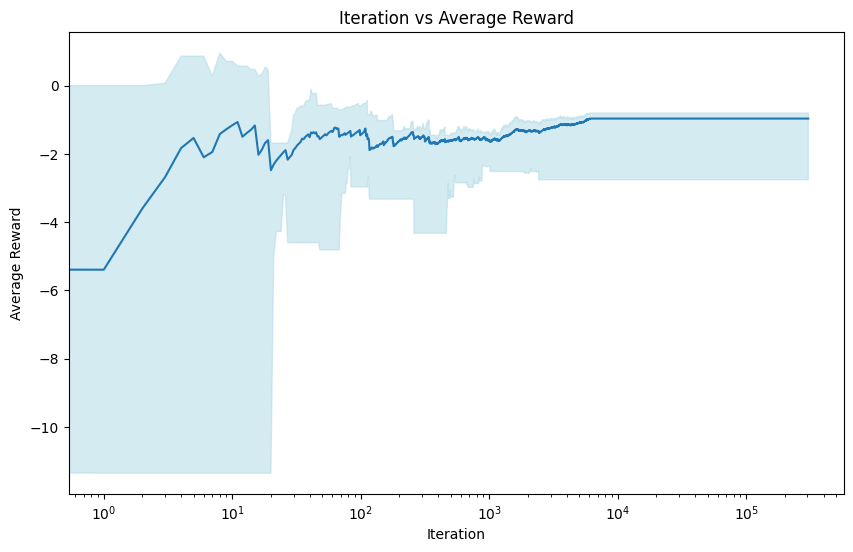

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
x_values = [i for i in range(len(plottingmaterials))]
y_values = [x[1] for x in plottingmaterials]
#plot min and max reward as a shaded area light blue
plt.fill_between(x_values, [x[2] for x in plottingmaterials], [x[3] for x in plottingmaterials], color='lightblue', alpha=0.5)
plt.plot(x_values, y_values)
plt.xlabel('Iteration')
plt.ylabel('Average Reward')
plt.title('Iteration vs Average Reward')
plt.xscale('log')
# plt.yscale('log')
plt.show()